In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
%matplotlib inline

### Data cleaning and merging

In [2]:
caseAbstractionsFileName = 'baseData/caseAbstractions-4-18-20.dta'
labDataFileName = 'baseData/ED_COVID_Data4_17_2020.csv'

In [3]:
caseAbstractions = pd.read_stata(caseAbstractionsFileName)
caseAbstractions['intubation_date'] = pd.to_datetime(caseAbstractions['intubation_date'], unit='ms')
caseAbstractions['shock_date'] = pd.to_datetime(caseAbstractions['shock_date'], unit='ms')
caseAbstractions = caseAbstractions.drop(caseAbstractions[caseAbstractions.outcome_reviewer.isnull()].index, axis='index')
caseAbstractions = caseAbstractions[['pat_enc_csn_id', 'mrn', 'hypertension', 'diabetes', 'asthma',
       'copd', 'chronic_lung', 'home_o2', 'osa', 'immunocompromised', 'pregnant', 'intubation', 'intubation_date',
                                    'shock', 'shock_date', 'dni_dnar', 'death', 'death_date']]
caseAbstractions['primaryOutcome'] = (caseAbstractions['intubation'] == 'Intubated') | (caseAbstractions['shock'] == 'Yes') | (caseAbstractions['death'] == 'Yes')
caseAbstractions['primaryOutcomeDate'] = caseAbstractions[['intubation_date', 'shock_date', 'death_date']].min(axis='columns')

for var in ['dni_dnar', 'hypertension', 'diabetes', 'asthma', 'copd', 'chronic_lung', 'home_o2', 'osa', 'immunocompromised', 'pregnant']:
    caseAbstractions[var] = caseAbstractions[var] == "Y"

caseAbstractions.head()

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:370: UserWarning: Encountered %tC format. Leaving in Stata Internal Format.
  warnings.warn("Encountered %tC format. Leaving in Stata " "Internal Format.")


pat_enc_csn_id        mrn  hypertension  diabetes  asthma   copd  \
0       272071328  101224505         False     False   False  False   
1       272254374  100340985         False     False   False  False   
2       272270483   28708828         False     False   False  False   
3       272529195   23334525         False     False   False  False   
4       272580543  100437568         False     False   False  False   

   chronic_lung  home_o2    osa  immunocompromised  pregnant  \
0         False    False  False              False     False   
1         False    False  False              False     False   
2         False    False  False              False     False   
3         False    False  False              False     False   
4         False    False  False              False     False   

                            intubation     intubation_date shock  \
0  Did not require supplemental oxygen                 NaT    No   
1                            Intubated 2030-03-13 13:40:27   Yes   
2  Did not require supplemental oxygen                 NaT    No   
3                            Intubated 2030-03-20 13:40:27    No   
4  Did not require supplemental oxygen                 NaT    No   

           shock_date  dni_dnar death death_date  primaryOutcome  \
0                 NaT     False    No        NaT           False   
1 2030-03-13 19:30:27     False   Yes 2020-03-30            True   
2                 NaT     False    No        NaT           False   
3                 NaT     False    No        NaT            True   
4                 NaT     False    No        NaT           False   

   primaryOutcomeDate  
0                 NaT  
1 2020-03-30 00:00:00  
2                 NaT  
3 2030-03-20 13:40:27  
4                 NaT

In [4]:
rawData = pd.read_csv(labDataFileName)

In [5]:
rawData.COVID19_POSTIVE.value_counts(dropna=False)

NaN    1629
Y       588
Name: COVID19_POSTIVE, dtype: int64

In [6]:
# identify covid cases
#rawData.loc[(rawData.ED_LAB_COVID19=="Positive") | (rawData.ED_LAB_COVID19=="Presumptive Positive"), 'ED_LAB_COVID19']  ="Detected"   
#rawData.loc[(rawData.ED_LAB_COVID19=="Not Detected"), 'ED_LAB_COVID19'] ="Not detected"  
#rawData = rawData.loc[(rawData.ED_LAB_COVID19 == 'Detected') | (rawData.ED_LAB_COVID19 == 'Not detected')]
rawData['covid'] = rawData.COVID19_POSTIVE=="Y"
rawData = rawData.loc[rawData.covid]

In [7]:
# clean outcomes
rawData.loc[(rawData.ED_PM_EXPIRED_IN_ED_YN=="Y"), 'ED_ADMIT_TO_ICU_YN'] = 1
rawData['icu'] = rawData.ED_ADMIT_TO_ICU_YN=="Y"


In [8]:
rawData.COVID19_POSTIVE.value_counts()

Y    588
Name: COVID19_POSTIVE, dtype: int64

In [9]:
pd.crosstab(rawData.covid, rawData.icu, dropna=False )

icu    False  True 
covid              
True     522     66

In [10]:
rawData.rename(columns={'AGE_AT_VISIT_YRS' : 'age', 'TRIAGE_SBP' : 'sbp', 'TRIAGE_DBP' : 'dbp',
                        'TRIAGE_HR' : 'hr', 'TRIAGE_TEMP' : 'temp', 'ED_LAB_CRP' : 'crp', 
                        'ED_LAB_DDIMER' : 'dDimer', 'ED_LAB_FERRITIN' : 'ferritin',
                        'ED_CBC_PLT' : 'platelets', 'ED_LAB_CMP_CR' : 'creatinine',  
                        'ED_LAB_CMP_TBILI' : 'tbili', 'ED_HSTROP0' : 'hsTrop', 
                        'ED_LAB_IL6' : 'il6', 'ED_CBC_LYM' : 'lymph',
                        'ED_CBC_HGB': 'hgb', 'ED_VBG_LAC':'lac', 'ED_LDH':'ldh',
                        'ED_LAB_CMP_ALB': 'albumin', 'TRIAGE_HR':'hr',
                        'TRIAGE_RR':'rr', 'TRIAGE_TEMP':'temp', 'ED_LAB_CMP_ALT' : 'alt', 
                        'ED_HSTROP2' : 'hsTrop2'}, inplace=True)

In [11]:
# truncate high low lab values and convert to floats
rawData.crp.replace('<0.2', 0.1, inplace=True)

rawData.dDimer.replace('<0.17', 0.085, inplace=True)
rawData.dDimer.replace('>35.00', 40, inplace=True)

rawData.ferritin.replace('>16500.0', 17000, inplace=True)
rawData.ferritin.replace('>1650.0', 17000, inplace=True)

rawData.il6.replace('>3670.0', 4100, inplace=True)
rawData.il6.replace('>4060.0', 4100, inplace=True)
rawData.il6.replace('<4.0', 2, inplace=True)


rawData.alt.replace('<8', 4, inplace=True)

rawData.hsTrop.replace('<6', 3, inplace=True)
rawData.hsTrop2.replace('<6', 3, inplace=True)

rawData.platelets.replace('<2', 1, inplace=True)
rawData.creatinine.replace('SEE BELOW', np.nan, inplace=True)
rawData.creatinine.replace('<0.10', 0.005, inplace=True)

rawData.hgb.replace('SEE BELOW', np.nan, inplace=True)
rawData.lac.replace('SEE BELOW', np.nan, inplace=True)

rawData.crp = rawData.crp.astype('float')
rawData.dDimer = rawData.dDimer.astype('float')
rawData.ferritin = rawData.ferritin.astype('float')
rawData.il6 = rawData.il6.astype('float')
rawData.alt = rawData.alt.astype('float')
rawData.hsTrop = rawData.hsTrop.astype('float')
rawData.hsTrop2 = rawData.hsTrop2.astype('float')
rawData.platelets = rawData.platelets.astype('float')
rawData.creatinine = rawData.creatinine.astype('float')
rawData.hgb =  rawData.hgb.astype('float')
rawData.lac =  rawData.lac.astype('float')
rawData.ldh =  rawData.ldh.astype('float')
rawData.albumin =  rawData.albumin.astype('float')
rawData.hr = rawData.hr.astype('float')
rawData.rr = rawData.rr.astype('float')

rawData.tbili = rawData.tbili.astype('float')



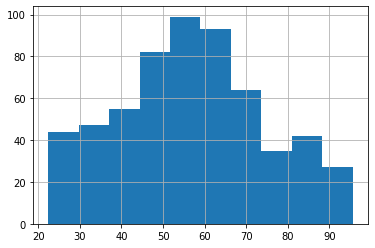

In [14]:
rawData.age.hist()

In [15]:
rawData.GENDER.value_counts()
rawData['female'] = rawData.GENDER=="F"
rawData.female = rawData.female.astype('int')

In [16]:
rawData['highFi02'] = rawData.TRIAGE_FIO2 > 50
rawData['highFi02'] = rawData['highFi02'].astype('int')

In [17]:
rawData = rawData[['age', 'female', 'sbp', 'dbp', 'hr', 'rr',
                   'temp', 'highFi02', 'crp', 'dDimer', 'ferritin', 
                   'platelets', 'lymph', 'creatinine', 'tbili', 
                   'hsTrop', 'il6', 'covid', 'icu', 'hgb', 'lac', 
                   'ldh', 'albumin', 'MRN', 'PAT_ENC_CSN_ID']] 

In [18]:
caseAbstractions = caseAbstractions.rename(columns={'mrn' : 'MRN', 'pat_enc_csn_id' : 'PAT_ENC_CSN_ID' })
caseAbstractions = caseAbstractions.drop(labels=['intubation', 'shock', 'death', 'intubation_date', 'shock_date', 'death_date'], axis='columns')
rawData = rawData.merge(caseAbstractions, on=['MRN', 'PAT_ENC_CSN_ID'])
rawData = rawData.drop(labels=['MRN', 'PAT_ENC_CSN_ID'], axis='columns')
rawData.to_stata('rawData.dta')

In [22]:
rawData['totalMissing'] = rawData.isnull().sum(axis=1)
for col in rawData.columns:
    if col in ['hr', 'rr', 'sbp', 'dbp', 'temp', 'crp', 'dDimer', 'ferritin', 'platelets', 
               'lymph', 'creatinine', 'tbili', 'hsTrop', 'il6', 'hgb', 'lac', 'ldh', 'albumin']:
        rawData[str(col)+"Missing"] = rawData[col].isnull()

In [23]:
for col in rawData.columns:
    if "Missing" in col:
        print(f"column: {col}, total missing: {rawData[col].sum()}, % missing: {rawData[col].sum()/len(rawData)}")

column: totalMissing, total missing: 1579, % missing: 4.8734567901234565
column: sbpMissing, total missing: 0, % missing: 0.0
column: dbpMissing, total missing: 0, % missing: 0.0
column: hrMissing, total missing: 0, % missing: 0.0
column: rrMissing, total missing: 0, % missing: 0.0
column: tempMissing, total missing: 0, % missing: 0.0
column: crpMissing, total missing: 112, % missing: 0.345679012345679
column: dDimerMissing, total missing: 118, % missing: 0.36419753086419754
column: ferritinMissing, total missing: 112, % missing: 0.345679012345679
column: plateletsMissing, total missing: 28, % missing: 0.08641975308641975
column: lymphMissing, total missing: 30, % missing: 0.09259259259259259
column: creatinineMissing, total missing: 29, % missing: 0.08950617283950617
column: tbiliMissing, total missing: 71, % missing: 0.2191358024691358
column: hsTropMissing, total missing: 209, % missing: 0.6450617283950617
column: il6Missing, total missing: 261, % missing: 0.8055555555555556
column:

### Imputation

In [24]:
# impute missing lab and vitals values

shortData = rawData[['age', 'female', 'sbp', 'dbp', 'crp', 'dDimer',  'ferritin', 'platelets', 
                     'creatinine', 'tbili', 'hsTrop', 'il6', 'lymph', 'hgb', 'lac', 'ldh', 'albumin',
                     'hr', 'rr',  'temp', 'icu', 'hypertension', 'diabetes', 'asthma', 'copd', 
                     'chronic_lung', 'home_o2', 'osa', 'immunocompromised', 'pregnant', 'primaryOutcome', 
                     'highFi02']]

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    return fml

imputedData = mice.MICEData(shortData)

for var in ['age', 'female', 'sbp', 'dbp', 'crp', 'dDimer', 'ferritin', 'platelets', 'creatinine', 
            'tbili', 'hsTrop', 'il6', 'lymph', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr',  'temp']:
    imputedData.set_imputer(var, formula=ols_formula(shortData, var))

imputedData.update_all(20)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


In [25]:
cleanedData = imputedData.data

In [26]:
withMissing = {}
for key in imputedData.models.keys():
    withMissing[key] = imputedData.models[key].fit().rsquared
withMissing

{'hgb': 0.4738318360324755,
 'platelets': 0.29853496284303416,
 'creatinine': 0.22745487244136575,
 'lymph': 0.32327015460032094,
 'albumin': 0.348358617933863,
 'tbili': 0.22014419759926562,
 'ferritin': 0.27370164171959943,
 'crp': 0.42213813274010814,
 'dDimer': 0.3332011132832492,
 'lac': 0.5200129670162611,
 'ldh': 0.538768699061126,
 'hsTrop': 0.6351535175942371,
 'il6': 0.37178003439483}

### Post imputation data management

In [27]:
cleanedData.rename(columns={'AGE_AT_VISIT_YRS' : 'age', 'TRIAGE_SBP' : 'sbp', 'TRIAGE_DBP' : 'dbp',
                            'TRIAGE_HR' : 'hr', 'TRIAGE_TEMP' : 'temp', 'ED_LAB_CRP' : 'crp', 
                            'ED_LAB_DDIMER' : 'dDimer', 'ED_LAB_FERRITIN' : 'ferritin',
                            'ED_LAB_CBC_PLT' : 'platelets', 'ED_LAB_CMP_CR' : 'creatinine',  
                            'ED_LAB_CMP_TBILI' : 'tbili', 'ED_LAB_HSTROP0' : 'hsTrop', 
                            'ED_LAB_IL6' : 'il6', 'ED_LAB_CBC_LYM' : 'lymph',
                            'ED_LAB_CBC_HGB': 'hgb', 'ED_LAB_VBG_LAC':'lac', 'ED_LAB_LDH':'ldh',
                            'ED_LAB_CMP_ALB': 'albumin', 'TRIAGE_HR':'hr',
                           'TRIAGE_RR':'rr', 'TRIAGE_TEMP':'temp'}, inplace=True)

In [28]:
# crude sofa score on imputed dataset
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence

# pao2/fi02
cleanedData['sofa'] = 0 # for the PaO2/fio2 ratio — looks like almost all our peopel are on room air, and we don't have pa02 on many 
cleanedData.loc[cleanedData.highFi02, 'sofa'] = 2 # crudely give elevated points for high Fi01, 

# platelets
sofaPlateletPoints = {0 : 4, 1 : 3, 2: 2, 3: 1, 4: 0}
cleanedData['plateletCat'] = pd.cut(cleanedData.platelets, [0, 20, 49, 99, 149, 10000]).values.codes
cleanedData['plateletPoints'] = [sofaPlateletPoints[cat] for cat in cleanedData.plateletCat]
cleanedData['sofa'] = cleanedData.sofa + cleanedData.plateletPoints

#gcs - missing...will just impute 0.2 points for eerybody...most are going to be very low
cleanedData['sofa'] = cleanedData.sofa + 0.2 

# t bili
cleanedData['biliCat'] = pd.cut(cleanedData.tbili, [0, 1.2, 1.99, 5.99, 11.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.biliCat

# blood pressure — no pressor data for now...
cleanedData['map'] = cleanedData.sbp * 1/3 + cleanedData.dbp * 2/3
cleanedData.loc[cleanedData.map < 70, 'sofa'] = cleanedData.sofa + 1

# creatinine
cleanedData['creatCat'] = pd.cut(cleanedData.creatinine, [0, 1.19, 1.99, 3.49, 4.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.creatCat


### Defining models

In [29]:
factorsWithPriors = ['age', 'female', 'sofa', 'lymph']
factorsWithoutPriors =  ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp', 'hypertension', 'diabetes',
       'asthma', 'copd', 'chronic_lung', 'home_o2', 'osa', 'immunocompromised']
missCols = [col for col in cleanedData.columns if "Missing" in col]
outcomes = ['icu', 'primaryOutcome']

allCols = factorsWithPriors.copy()
allCols.extend(factorsWithoutPriors)
allCols.extend(missCols)
allPredictors = allCols.copy()
allCols.extend(outcomes)


modelData = cleanedData[allCols]

In [30]:
modelData.head()

age  female  sofa  lymph   crp  dDimer  ferritin  hsTrop   hgb  lac  \
0  58.529       0   5.2   26.2   0.5    3.09     100.0    25.0  15.8  2.9   
1  57.913       0   3.2   19.1   0.1    0.56     289.9    82.0  12.1  1.1   
2  58.966       0   2.2   18.2  19.0    1.76     356.8    48.0   9.5  0.8   
3  52.980       0   1.2    2.2  31.6    1.28    1366.2    14.0  14.9  2.4   
4  59.241       0   0.2    7.1   6.4    0.82     946.0     7.0  12.6  0.8   

   ...  hypertension  diabetes  asthma   copd  chronic_lung  home_o2    osa  \
0  ...         False     False   False  False         False    False  False   
1  ...         False     False   False  False         False    False  False   
2  ...         False     False   False  False         False    False  False   
3  ...         False     False   False  False         False    False  False   
4  ...         False     False   False  False         False    False  False   

   immunocompromised    icu  primaryOutcome  
0              False  False           False  
1              False   True           False  
2              False  False            True  
3              False   True            True  
4              False  False           False  

[5 rows x 25 columns]

In [31]:
modelData.icu.value_counts()

False    279
True      45
Name: icu, dtype: int64

In [32]:
modelData.primaryOutcome.value_counts()

False    263
True      61
Name: primaryOutcome, dtype: int64

In [33]:
# crude priors from:  Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study. The Lancet, 1–9. http://doi.org/10.1016/S0140-6736(20)30566-3
import pymc3 as pm

# mean center all the variables...
#for var in ['crp', 'dDimer', 'ferritin', 'hsTrop', 'sofa','lymph', 'hbg', 'lac', 'ldh', 'albumin']:
#     modelData[var] = modelData[var] - modelData[var].mean()


In [34]:
def getBetaNameForLab(lab):
    return 'beta' + lab.capitalize()

In [35]:
# primary outcome model
with pm.Model() as logitPrimaryOutcome:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for factor in factorsWithoutPriors:
        name = getBetaNameForLab(factor)
        setattr(logitPrimaryOutcome, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(logitPrimaryOutcome, factor, pm.Data(factor, modelData[factor]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
        betaFemale * modelData.female 
    
    for factor  in factorsWithoutPriors:   
        mu += getattr(logitPrimaryOutcome, getBetaNameForLab(factor)) * getattr(logitPrimaryOutcome, factor)
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.primaryOutcome)

    tracePrimaryOutcome = pm.sample(1000, tune=3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaImmunocompromised, betaOsa, betaHome_o2, betaChronic_lung, betaCopd, betaAsthma, betaDiabetes, betaHypertension, betaTemp, betaRr, betaHr, betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [02:18<00:00, 115.21draws/s]


In [36]:
# main ICU model
with pm.Model() as logitICUWIthPriors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for factor in factorsWithoutPriors:
        name = getBetaNameForLab(factor)
        setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(logitICUWIthPriors, factor, pm.Data(factor, modelData[factor]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
        betaFemale * modelData.female 
    
    for factor in factorsWithoutPriors:
        mu += getattr(logitICUWIthPriors, getBetaNameForLab(factor)) * getattr(logitICUWIthPriors, factor)
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

    trace_ICU = pm.sample(1000, tune=3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaImmunocompromised, betaOsa, betaHome_o2, betaChronic_lung, betaCopd, betaAsthma, betaDiabetes, betaHypertension, betaTemp, betaRr, betaHr, betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [02:05<00:00, 127.89draws/s]


In [37]:
# # icu model that includes missing variable flags
# def getBetaNameForLab(lab):
#     return 'beta' + lab.capitalize()

# labs = ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp']
# missCols = [col for col in modelData.columns if "Missing" in col]

# with pm.Model() as logitICUWIthPriors:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
#     betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
#     betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
#     betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
#     betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)
#     #betaTotalMissing = pm.Normal('betaTotalMissing', mu=0, sd=10)
#     #totalMissing = pm.Data('totalMissing', modelData.totalMissing)

#     # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
#     for lab in labsVitals:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
#     # explore individual missing variables
#     for lab in missCols:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
        
#     # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
#     mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
#         betaFemale * modelData.female 
    
#     for lab  in labsVitals:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
#     for lab  in missCols:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)


#     θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
#     y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

#     trace_ICU_Missing = pm.sample(1000, tune=3000, cores=4)

In [38]:
# # icu model on the dataset with minimal missingess
# def getBetaNameForLab(lab):
#     return 'beta' + lab.capitalize()

# with pm.Model() as logitICUWIthPriors:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
#     betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
#     betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
#     betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
#     betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


#     # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
#     for lab in labsVitals:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, noMissing[lab]))
        
    
#     # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
#     mu = alpha + betaAge * noMissing.age + betaSofa * noMissing.sofa + betaLymph * noMissing.lymph + \
#         betaFemale * noMissing.female 
    
#     for lab  in labsVitals:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
#     θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
#     y_1 = pm.Bernoulli('y_1', p=θ, observed=noMissing.icu)

#     trace_ICU_NoMissing = pm.sample(1000, tune=3000, cores=4)

### Reporting

In [39]:
def assessOverallPerformance(model, trace, name):
    ppcs = pm.sample_ppc(trace, model=model, samples=1000)
    posteriorName = 'posterior' + name

    modelData[posteriorName] = ppcs['y_1'].mean(axis=0)

    preds = np.rint(modelData[posteriorName]).astype('int')
    print(f'Accuracy: {accuracy_score(modelData.icu, preds):.3f}')
    print(f'f1 score: {f1_score(modelData.icu, preds):.3f}')
    roc = roc_auc_score(modelData.icu, modelData[posteriorName])
    print(f'ROC: {roc:.3f}')
    return ppcs, roc

In [40]:
def assessParameterInfluence(model, trace):   
    labsToKeep = []
    marginalOutputsForLab = {}
    marginalInputsForLab = {}
    ninetyMinusTenForLab = {}

    labs=['totalMissing']


    for var in factorsWithoutPriors:
        with model:
            valuesToCheck = {'min': modelData[var].min(), '1st':modelData[var].quantile(0.01),
                             '10th':modelData[var].quantile(0.10), '25th':modelData[var].quantile(0.25), 
                             '50th':modelData[var].quantile(0.50), '75th':modelData[var].quantile(0.75), 
                             '90th':modelData[var].quantile(0.90), '99th':modelData[var].quantile(0.99),
                             'max':modelData[var].max()}
            ppcsAtValue = dict.fromkeys(valuesToCheck.keys())

            for key, value in valuesToCheck.items():
                pm.model.set_data({var: np.repeat(value, len(modelData))})
                pccsForLabValue = pm.sample_posterior_predictive(trace, samples=1000, progressbar=False)
                ppcsAtValue[key] = pccsForLabValue['y_1'].mean(axis=0).mean()
                marginalOutputsForLab[var] = ppcsAtValue
                marginalInputsForLab[var] = valuesToCheck
            ninetyMinusTen = ppcsAtValue['90th'] - ppcsAtValue['10th']
            ninetyMinusTenForLab[var] = ninetyMinusTen

            if np.abs(ninetyMinusTen) > 0.05:
                labsToKeep.append(var)
    return (labsToKeep, marginalOutputsForLab, marginalInputsForLab, ninetyMinusTenForLab)

In [41]:
def getDataObject(model, trace, ppc):
    with model:

        data = az.from_pymc3(
            trace=trace,
            prior=pm.sample_prior_predictive(),
            posterior_predictive=ppc,
            model=model
        )
    return data


### Assess primary outcome

In [42]:
primaryPPCs, primaryROC = assessOverallPerformance(logitPrimaryOutcome, tracePrimaryOutcome, "PrimaryOutcome")
primaryToKeep, primaryMarignalOutputs, primaryMarginalInputs, primaryNinetyMinusTen = assessParameterInfluence(logitPrimaryOutcome, tracePrimaryOutcome)
primaryData = getDataObject(logitPrimaryOutcome, tracePrimaryOutcome, primaryPPCs )

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 528.65it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarnin

Accuracy: 0.870
f1 score: 0.488
ROC: 0.838


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sam

In [43]:
az.summary(tracePrimaryOutcome).head(24)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
alpha                 -9.230  4.354 -17.376   -1.171      0.070    0.053   
betaAge                0.043  0.012   0.020    0.065      0.000    0.000   
betaSofa               0.196  0.147  -0.099    0.456      0.002    0.002   
betaLymph             -0.034  0.023  -0.078    0.007      0.000    0.000   
betaFemale            -0.539  0.248  -1.031   -0.101      0.003    0.002   
betaCrp                0.033  0.022  -0.007    0.077      0.000    0.000   
betaDdimer             0.023  0.027  -0.025    0.074      0.000    0.000   
betaFerritin           0.000  0.000  -0.000    0.000      0.000    0.000   
betaHstrop             0.006  0.005  -0.003    0.014      0.000    0.000   
betaHgb                0.016  0.043  -0.062    0.098      0.001    0.001   
betaLac                0.018  0.049  -0.070    0.111      0.001    0.001   
betaLdh                0.003  0.001   0.001    0.005      0.000    0.000   
betaAlbumin            0.008  0.049  -0.082    0.103      0.001    0.001   
betaHr                 0.016  0.011  -0.004    0.036      0.000    0.000   
betaRr                 0.071  0.026   0.023    0.120      0.000    0.000   
betaTemp               0.003  0.041  -0.075    0.078      0.001    0.001   
betaHypertension       0.001  0.050  -0.094    0.098      0.001    0.001   
betaDiabetes          -0.000  0.050  -0.096    0.092      0.001    0.001   
betaAsthma             0.000  0.051  -0.094    0.097      0.001    0.001   
betaCopd              -0.000  0.049  -0.091    0.091      0.001    0.001   
betaChronic_lung       0.000  0.049  -0.094    0.090      0.001    0.001   
betaHome_o2           -0.001  0.050  -0.096    0.092      0.001    0.001   
betaOsa               -0.000  0.050  -0.096    0.091      0.001    0.001   
betaImmunocompromised -0.001  0.050  -0.098    0.092      0.001    0.001   

                       ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
alpha                    3843.0  3344.0    3842.0    2920.0    1.0  
betaAge                  5321.0  4909.0    5313.0    3059.0    1.0  
betaSofa                 4684.0  3697.0    4694.0    2755.0    1.0  
betaLymph                4757.0  3794.0    4753.0    2586.0    1.0  
betaFemale               6070.0  4963.0    6101.0    2873.0    1.0  
betaCrp                  4954.0  3882.0    4955.0    3330.0    1.0  
betaDdimer               5937.0  3188.0    5950.0    2940.0    1.0  
betaFerritin             4428.0  2672.0    4484.0    2857.0    1.0  
betaHstrop               4456.0  3820.0    4445.0    3410.0    1.0  
betaHgb                  5492.0  2124.0    5497.0    2935.0    1.0  
betaLac                  5248.0  1702.0    5265.0    2746.0    1.0  
betaLdh                  4280.0  3877.0    4300.0    2780.0    1.0  
betaAlbumin              6175.0  1858.0    6172.0    2873.0    1.0  
betaHr                   5479.0  4259.0    5488.0    3234.0    1.0  
betaRr                   5461.0  4684.0    5464.0    2854.0    1.0  
betaTemp                 3982.0  1878.0    3988.0    2963.0    1.0  
betaHypertension         5298.0  1549.0    5304.0    2610.0    1.0  
betaDiabetes             5552.0  1719.0    5561.0    2967.0    1.0  
betaAsthma               5937.0  1641.0    5957.0    2964.0    1.0  
betaCopd                 5740.0  2075.0    5739.0    3502.0    1.0  
betaChronic_lung         6077.0  1993.0    6102.0    2872.0    1.0  
betaHome_o2              6435.0  1624.0    6426.0    2803.0    1.0  
betaOsa                  5981.0  1494.0    5963.0    2736.0    1.0  
betaImmunocompromised    6130.0  1495.0    6108.0    2448.0    1.0

In [44]:
primaryNinetyMinusTen

{'crp': 0.05990740740740741,
 'dDimer': 0.009820987654321045,
 'ferritin': 0.03676851851851859,
 'hsTrop': 0.029864197530864,
 'hgb': 0.005064814814814689,
 'lac': 0.0019845679012344686,
 'ldh': 0.09564814814814837,
 'albumin': -0.0008024691358023972,
 'hr': 0.01758950617283972,
 'rr': 0.01422839506172846,
 'temp': 0.00017283950617275057,
 'hypertension': 6.172839506102257e-06,
 'diabetes': 1.2345679012426558e-05,
 'asthma': 0.00014197530864201724,
 'copd': -0.0001820987654321815,
 'chronic_lung': -9.876543209863531e-05,
 'home_o2': 0.00020987654321003024,
 'osa': -1.2345679012204513e-05,
 'immunocompromised': -1.2345679012426558e-05}

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c34b35710>,
      dtype=object)

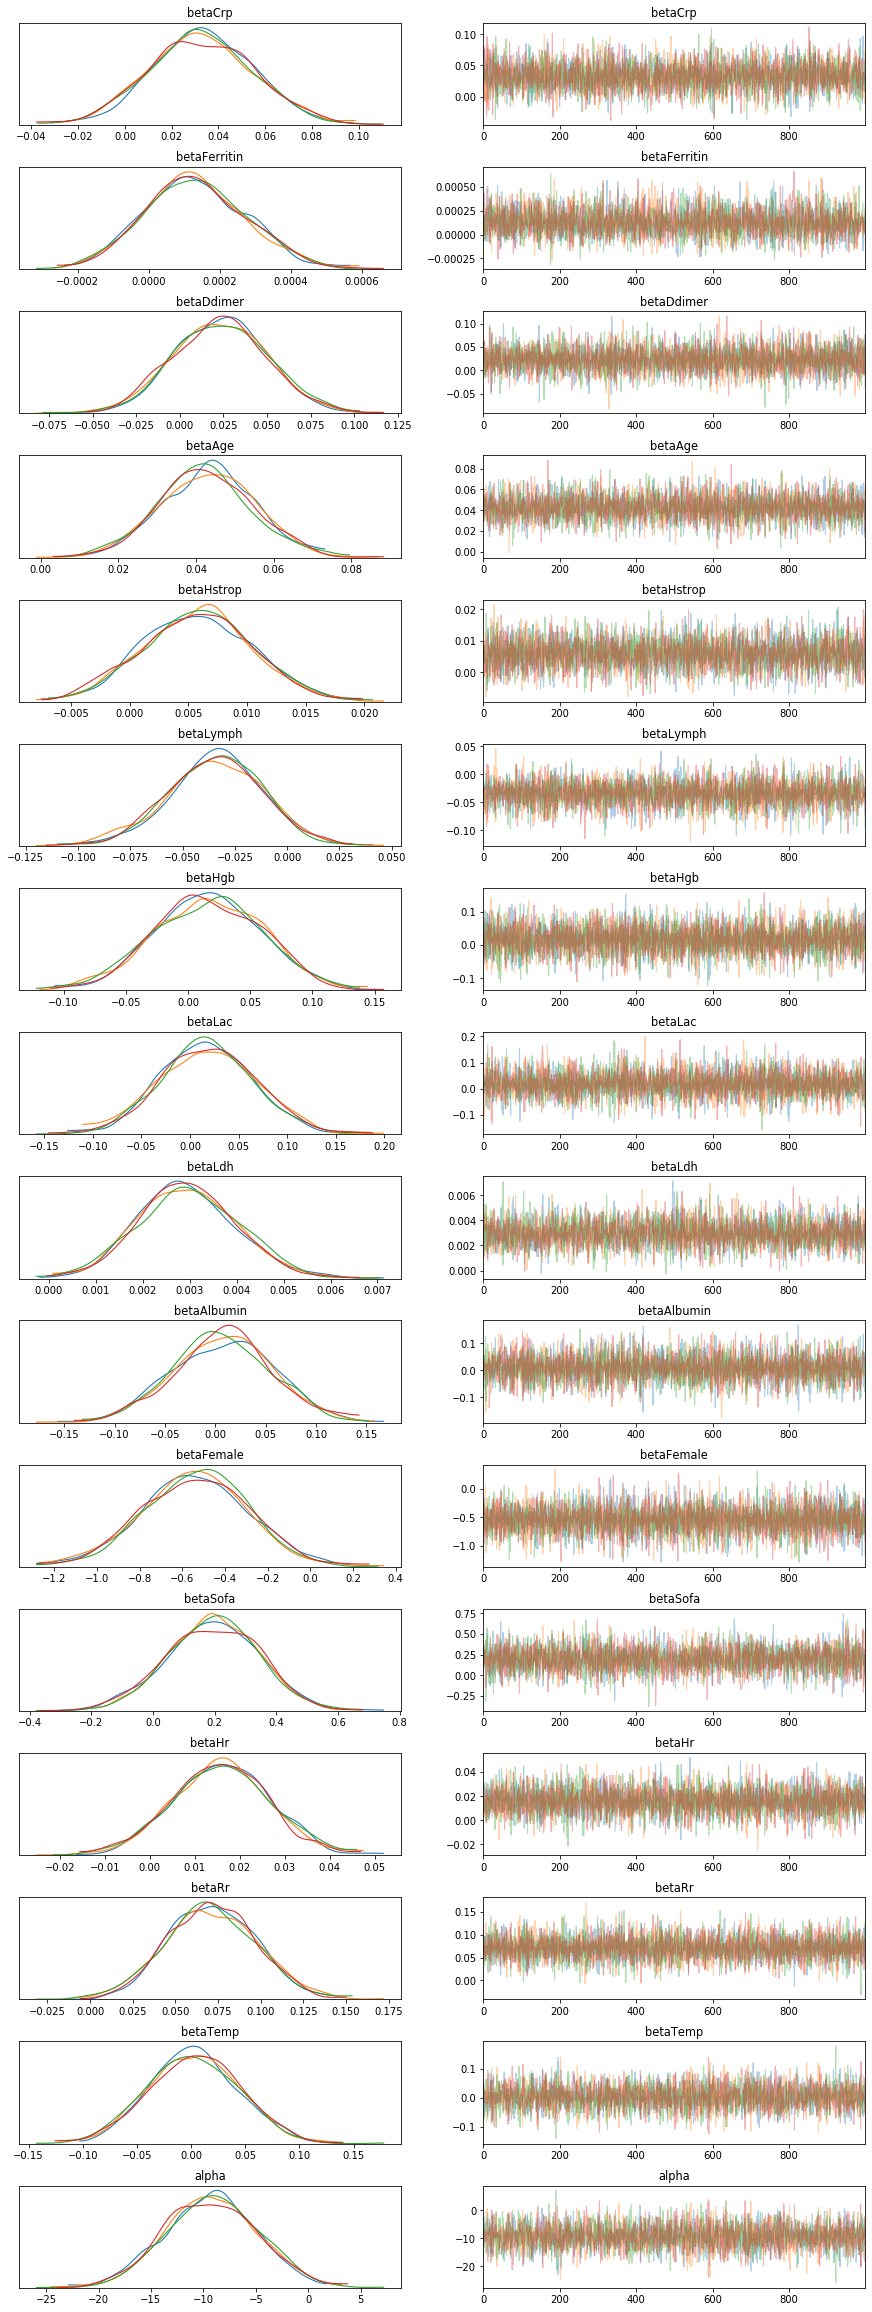

In [45]:
az.plot_trace(tracePrimaryOutcome, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                    'betaFemale', 'betaSofa', 'betaHr', 'betaRr', 'betaTemp', 'alpha'])

### ICU Model

In [46]:
icuPPCs, icuROC = assessOverallPerformance(logitICUWIthPriors, trace_ICU, "ICU")
icuToKeep, icuMarignalOutputs, icuMarginalInputs, icuNinetyMinusTen = assessParameterInfluence(logitICUWIthPriors, trace_ICU)
icuData = getDataObject(logitICUWIthPriors, trace_ICU, icuPPCs )

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 531.13it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarnin

Accuracy: 0.904
f1 score: 0.551
ROC: 0.858


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sam

In [47]:
az.summary(trace_ICU).head(16)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
alpha        -5.995  4.458 -14.285    2.318      0.083    0.064    2898.0   
betaAge       0.022  0.014  -0.003    0.049      0.000    0.000    4286.0   
betaSofa      0.193  0.169  -0.119    0.515      0.003    0.002    3237.0   
betaLymph    -0.030  0.027  -0.084    0.018      0.000    0.000    3816.0   
betaFemale   -0.306  0.247  -0.790    0.133      0.004    0.003    4718.0   
betaCrp       0.028  0.024  -0.015    0.074      0.000    0.000    4151.0   
betaDdimer    0.017  0.029  -0.036    0.071      0.000    0.000    4648.0   
betaFerritin  0.000  0.000  -0.000    0.000      0.000    0.000    3666.0   
betaHstrop    0.002  0.005  -0.008    0.012      0.000    0.000    3376.0   
betaHgb       0.008  0.045  -0.075    0.093      0.001    0.001    4488.0   
betaLac       0.002  0.049  -0.090    0.097      0.001    0.001    4465.0   
betaLdh       0.006  0.001   0.003    0.008      0.000    0.000    3824.0   
betaAlbumin  -0.003  0.050  -0.094    0.091      0.001    0.001    4864.0   
betaHr        0.001  0.012  -0.021    0.024      0.000    0.000    3959.0   
betaRr        0.061  0.026   0.013    0.112      0.000    0.000    4206.0   
betaTemp     -0.015  0.042  -0.096    0.061      0.001    0.001    3129.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
alpha         2459.0    2890.0    2660.0   1.00  
betaAge       3505.0    4348.0    2829.0   1.00  
betaSofa      3095.0    3270.0    2710.0   1.00  
betaLymph     2297.0    3952.0    2251.0   1.00  
betaFemale    3368.0    4719.0    2994.0   1.00  
betaCrp       3373.0    4179.0    3397.0   1.00  
betaDdimer    2396.0    4705.0    2637.0   1.01  
betaFerritin  1838.0    3769.0    2374.0   1.00  
betaHstrop    2326.0    3407.0    2827.0   1.00  
betaHgb       1822.0    4491.0    2509.0   1.00  
betaLac       1681.0    4478.0    2754.0   1.00  
betaLdh       3537.0    3857.0    2905.0   1.00  
betaAlbumin   1583.0    4892.0    2547.0   1.00  
betaHr        1889.0    3957.0    2555.0   1.00  
betaRr        4143.0    4198.0    2925.0   1.00  
betaTemp      2087.0    3127.0    2649.0   1.00

In [48]:
icuNinetyMinusTen

{'crp': 0.03871604938271607,
 'dDimer': 0.00541975308641976,
 'ferritin': 0.009333333333333305,
 'hsTrop': 0.012240740740740608,
 'hgb': 0.003429012345679161,
 'lac': 0.0006203703703704377,
 'ldh': 0.2531666666666666,
 'albumin': 0.00042901234567904734,
 'hr': 0.001651234567901283,
 'rr': 0.023700617283950787,
 'temp': -0.0006203703703704377,
 'hypertension': 0.00032716049382719437,
 'diabetes': -8.950617283953743e-05,
 'asthma': -0.0006111111111110068,
 'copd': 0.00012345679012348842,
 'chronic_lung': 0.00018518518518528815,
 'home_o2': 0.00011419753086427953,
 'osa': -9.567901234563969e-05,
 'immunocompromised': -1.8518518518417793e-05}

### Calibration 

In [49]:
outputDF = pd.DataFrame({'predicted icu' : modelData.posteriorICU, 'icu' : modelData.icu,
                         'predicted primary outcome' : modelData.posteriorPrimaryOutcome,
                         'primary outcome' : modelData.primaryOutcome})
outputDF['icuDecile'] = pd.qcut(outputDF['predicted icu'], 10)
outputDF['primaryOutcomeDecile'] = pd.qcut(outputDF['predicted primary outcome'], 10)

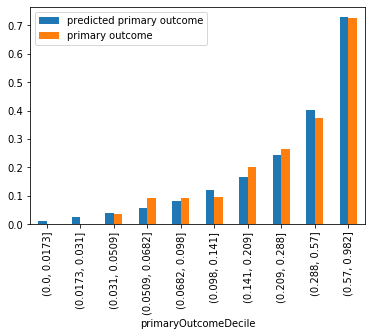

In [50]:
# primary outcome
from datetime import date
outputDF[['predicted primary outcome', 'primary outcome', 'primaryOutcomeDecile']].groupby('primaryOutcomeDecile').mean().plot.bar()
plt.savefig(f'static/primaryOutcomeCalibration{str(date.today())}.jpg')


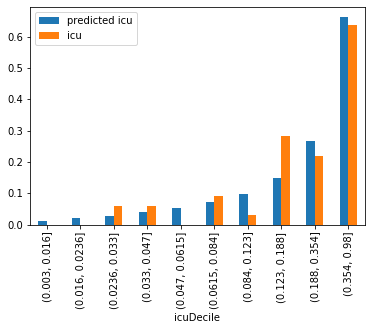

In [51]:
# icu
outputDF[['predicted icu', 'icu', 'icuDecile']].groupby('icuDecile').mean().plot.bar()
plt.savefig(f'static/icuCalibration{str(date.today())}.jpg')

In [52]:
def saveModelOutcomes(trace, ninetyMinusTen, name):
    modelCoefficients = az.summary(trace, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa',  'betaHr', 'betaRr', 'betaTemp', 'alpha'])[['mean', 'sd']]
    modelCoefficients.rename(columns={'mean': 'beta', 'sd':'sdBeta'}, inplace=True)
    for key, value in ninetyMinusTen.items():
        modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'priority'] = np.abs(value)
        modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'p50'] = modelData[key].quantile(0.50)
    
    for i, row in modelCoefficients.iterrows():
        if row.name[0:4] == 'beta':
            modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name[4:].lower()
        else:
            modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name
    modelCoefficients.to_stata(f'{name}Coeffs-{str(date.today())}.dta')
    return modelCoefficients


In [53]:
icuCoeffs = saveModelOutcomes(trace_ICU, icuNinetyMinusTen, "ICU")
primaryCoeffs = saveModelOutcomes(tracePrimaryOutcome, primaryNinetyMinusTen, "PrimaryOutcome")
modelData.to_stata(f'modelData-{str(date.today())}.dta')

In [54]:
import json


modelPerformance = {}
modelPerformance['icuROC'] = icuROC
modelPerformance['primaryROC'] = primaryROC

with open(f'modelPerformance-{str(date.today())}.json', 'w') as outfile:
    json.dump(modelPerformance, outfile)

In [55]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y=modelData["posteriorICU"], name="ICU Risk Distribution"), )
fig.add_trace(go.Box(y=modelData["posteriorPrimaryOutcome"], name="Primary Outcome Risk Distribution"), )

fig.add_trace(go.Scatter(y=[0.5]))
fig.show()

In [35]:
# workflow...

# download data
# clean datat (in this worksheet)
# impute missing values
# run baseline model
# prioritize coefficients
# export coefficients, data file and model performance
# update the priority in teh UI — done
# 

In [36]:
# there is a fairly reasonable agreement between our baseline bayesian model and a default-tuned elastic net
# that seesm liek a decent argument that our pessimism was calibrated reasonably...

In [37]:
# from glmnet import LogitNet

# m = LogitNet()
# m = m.fit(modelData.loc[:,!modelData.columns.in(['icu', 'posteriorProbabilities']), modelData.icu)

SyntaxError: invalid syntax (<ipython-input-37-3e104641e805>, line 4)

In [ ]:
#modelData

In [ ]:
#m.coef_